In [22]:
from ragraph.io.esl import from_esl
graph = from_esl(["./esl"])

import raesl.plot
figure = raesl.plot.mdm(
    graph,
    node_kinds=["component"],
)
figure.show()

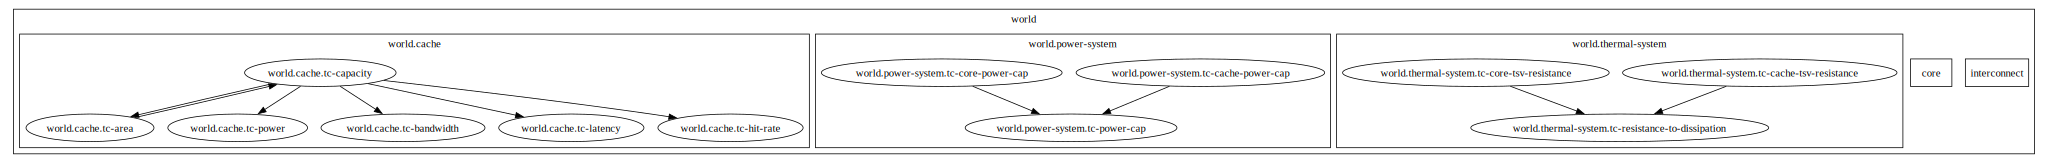

In [23]:
digraph = raesl.plot.functional_dependency_diagram(
    graph,
    root=graph["world"],
    levels=1,
)
digraph

In [24]:
figure = raesl.plot.mdm(
    graph,
    node_kinds=["component", "function_spec"],
    edge_kinds=["functional_dependency", "mapping_dependency"],
    depth=2,
)
figure.show()

In [25]:
from ragraph.analysis import heuristics

# Cluster components
heuristics.markov_gamma(
    graph=graph,
    alpha=1,    # Expension parameter.
    beta=2.0,   # Inflation parameter.
    mu=2.0,     # Evaporation parameter.
    gamma=2.0,   # Bus detection parameter.
    leafs = [node.name for node in graph.nodes if node.kind == "component" and node.is_leaf],
    inplace=True
)

# Reloaded MDM based on clustered graph.
figure = raesl.plot.mdm(
    graph,
    node_kinds=["component", "function_spec"],
    edge_kinds=["functional_dependency", "mapping_dependency"],
    depth=10,
)

figure

In [26]:
from ragraph.analysis import sequence
from raesl.plot.view_funcs import multi_domain
import ragraph.plot

# Select correct nodes and edges to be displayed.
nodes, edges = multi_domain(
    graph,
    node_kinds=["component", "function_spec"],
    edge_kinds=["functional_dependency", "mapping_dependency"],
    depth=4
)

leaf_comps = [n for n in nodes if n.kind == "component"]
leaf_funcs = [n for n in nodes if n.kind == "function_spec"]

# Sequence functions.
_, _, sequenced_functions = sequence.utils.branchsort(algo=sequence.scc_tearing, graph=graph, algo_args=dict(inf=1, dep=1, mu=3), inplace=True, nodes=leaf_funcs)

# Reload figure based on sequence.
figure = ragraph.plot.mdm(
    leafs = leaf_comps + sequenced_functions,
    edges = edges,
    style= ragraph.plot.Style(
        piemap=dict(
            display="labels",
            mode="relative",
            fields=graph.edge_labels
        ),
    )
)

figure